### **Install and import library**

In [ ]:
pip install pyvi

     |████████████████████████████████| 8.5 MB 5.0 MB/s 
     |████████████████████████████████| 743 kB 35.7 MB/s 


In [ ]:
from google.colab import drive
import os
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pyvi.ViTokenizer import ViTokenizer
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPool2D, Bidirectional, LSTM, GRU, concatenate, GlobalMaxPooling1D, GlobalAveragePooling1D, SpatialDropout1D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import text, sequence
from keras import backend as K
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

### **Connect to Google Drive**

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DIR_ROOT = '/gdrive/MyDrive/FakeCommentDetection'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')
EMBEDDING_PATH = os.path.join(DIR_ROOT, 'cc.vi.300.vec')
TOKENIZER_PATH = os.path.join(DIR_ROOT, 'tokenizer.pickle')

MODEL_DIR = os.path.join(DIR_ROOT, 'model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
def show_predict_result(model, X_test, y_test, labels):
    prediction = model.predict(X_test, batch_size=256, verbose=0)
    y_pred = prediction.argmax(axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels , columns = labels)
    sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))

### **Load data**

In [ ]:
data_train = pd.read_csv(PATH_TRAIN)
X_train = data_train.iloc[:, 0:2]
y_train = data_train.iloc[:, 2:4]

data_dev = pd.read_csv(PATH_DEV)
X_dev = data_dev.iloc[:, 0:2]
y_dev = data_dev.iloc[:, 2:4]


data_test = pd.read_csv(PATH_TEST)
X_test = data_test.iloc[:, 0:2]
y_test = data_test.iloc[:, 2:4]

In [ ]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text


def pre_process_features(X, y1, y2, tokenized = True, lowercased = True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            X = np.delete(X, idx)
            y1 = np.delete(y1, idx)
            y2 = np.delete(y2, idx)
    return X, y1, y2


def make_featues(X, y1, y2, tokenizer, is_one_hot_label=True, number_class1=2, number_class2=4):
    X = tokenizer.texts_to_sequences(X)
    X = sequence.pad_sequences(X, maxlen=sequence_length)
    if is_one_hot_label: 
        y1 = to_categorical(y1, num_classes=number_class1)
        y2 = to_categorical(y2, num_classes=number_class2)

    return X, y1, y2

In [ ]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = True)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = True)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = True)

In [ ]:
embeddings_index = {}
with open(EMBEDDING_PATH, encoding='utf8') as f:
    for line in f:
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [ ]:
tokenizer = text.Tokenizer(lower=False, filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(train_X)
with open(TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
labels_task_1 = ["no-spam", "spam"]
labels_task_2 = ["no-spam", "spam-1", "spam-2", "spam-3"]

vocabulary_size = 10000
sequence_length = 100

embedding_dim = 300
batch_size = 256
epochs = 40
drop = 0.5

filter_sizes = [2,3,5]
num_filters = 32

word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
train_X, train_y, train_y_spam = make_featues(train_X, train_y, train_y_spam, tokenizer)
dev_X, dev_y, dev_y_spam = make_featues(dev_X, dev_y, dev_y_spam, tokenizer)
test_X, test_y, test_y_spam = make_featues(test_X, test_y, test_y_spam, tokenizer, is_one_hot_label=False)

### **Text CNN**

#### **Task 1**

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool1D(3, strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool1D(3, strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool1D(3, strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=2, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 300)     5031600     input_1[0][0]                    
__________________________________________________________________________________________________
reshape (Reshape)               (None, 100, 300, 1)  0           embedding[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 99, 1, 32)    19232       reshape[0][0]                    
______________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(dev_X, dev_y))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
56/56 [==============================] - 60s 448ms/step - loss: 0.6050 - accuracy: 0.7058 - val_loss: 0.5455 - val_accuracy: 0.7288
Epoch 2/40
56/56 [==============================] - 21s 378ms/step - loss: 0.5329 - accuracy: 0.7421 - val_loss: 0.5207 - val_accuracy: 0.7294
Epoch 3/40
56/56 [==============================] - 21s 377ms/step - loss: 0.5100 - accuracy: 0.7621 - val_loss: 0.5067 - val_accuracy: 0.7665
Epoch 4/40
56/56 [==============================] - 21s 375ms/step - loss: 0.4958 - accuracy: 0.7838 - val_loss: 0.4946 - val_accuracy: 0.7722
Epoch 5/40
56/56 [==============================] - 21s 376ms/step - loss: 0.4815 - accuracy: 0.7909 - val_loss: 0.4839 - val_accuracy: 0.7760
Epoch 6/40
56/56 [==============================] - 21s 380ms/step - loss: 0.4702 - accuracy: 0.7983 - val_loss: 0.4745 - val_accuracy: 0.7873
Epoch 7/40
56/56 [==============================] - 21s 376ms/step - loss: 0.4584 - accuracy: 0.8039 - val_loss: 0.4656 - val_accuracy: 0.7898

In [ ]:
TEXT_CNN_MODEL = os.path.join(MODEL_DIR, 'Text_CNN_task1.h5')
model.save(TEXT_CNN_MODEL, save_format='h5')

F1 - micro: 0.8329974811083124
F1 - macro: 0.7703935361851905
Accuracy: 0.8329974811083123


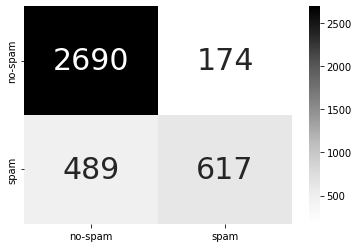

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

#### **Task 2**

In [ ]:
inputs = Input(shape=(sequence_length,), dtype='int32')
embedding = Embedding(input_dim=num_words, output_dim=embedding_dim, input_length=sequence_length, weights=[embedding_matrix])(inputs)
reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='elu')(reshape)

maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
dropout = Dropout(drop)(flatten)
output = Dense(units=4, activation='softmax')(dropout)

model = Model(inputs=inputs, outputs=output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 300)     5031600     input_2[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 100, 300, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 99, 1, 32)    19232       reshape_1[0][0]                  
____________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(dev_X, dev_y_spam))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
56/56 [==============================] - 22s 382ms/step - loss: 0.9440 - accuracy: 0.7078 - val_loss: 0.7992 - val_accuracy: 0.7300
Epoch 2/40
56/56 [==============================] - 21s 377ms/step - loss: 0.7740 - accuracy: 0.7438 - val_loss: 0.7405 - val_accuracy: 0.7338
Epoch 3/40
56/56 [==============================] - 21s 378ms/step - loss: 0.7241 - accuracy: 0.7518 - val_loss: 0.7073 - val_accuracy: 0.7382
Epoch 4/40
56/56 [==============================] - 21s 382ms/step - loss: 0.6858 - accuracy: 0.7715 - val_loss: 0.6832 - val_accuracy: 0.7741
Epoch 5/40
56/56 [==============================] - 21s 377ms/step - loss: 0.6610 - accuracy: 0.7899 - val_loss: 0.6641 - val_accuracy: 0.7791
Epoch 6/40
56/56 [==============================] - 21s 380ms/step - loss: 0.6372 - accuracy: 0.7988 - val_loss: 0.6464 - val_accuracy: 0.7816
Epoch 7/40
56/56 [==============================] - 21s 373ms/step - loss: 0.6176 - accuracy: 0.8015 - val_loss: 0.6302 - val_accuracy: 0.7854

In [ ]:
TEXT_CNN_MODEL = os.path.join(MODEL_DIR, 'Text_CNN_task2.h5')
model.save(TEXT_CNN_MODEL, save_format='h5')

F1 - micro: 0.830478589420655
F1 - macro: 0.6414031582899572
Accuracy: 0.8304785894206549


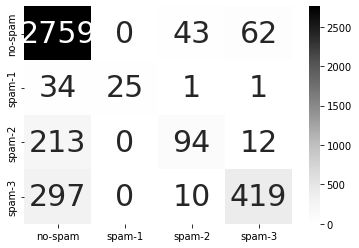

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)

### **BiLSTM**

#### **Task 1**

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(2, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 100, 300)     5031600     input_3[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 100, 300)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 128)     186880      spatial_dropout1d[0][0]          
____________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(dev_X, dev_y))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56/56 [==============================] - 10s 86ms/step - loss: 0.6670 - accuracy: 0.6362 - val_loss: 0.6187 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 4s 69ms/step - loss: 0.5660 - accuracy: 0.7401 - val_loss: 0.5496 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 4s 69ms/step - loss: 0.5256 - accuracy: 0.7403 - val_loss: 0.5219 - val_accuracy: 0.7294
Epoch 4/40
56/56 [==============================] - 4s 68ms/step - loss: 0.4937 - accuracy: 0.7491 - val_loss: 0.4887 - val_accuracy: 0.7520
Epoch 5/40
56/56 [==============================] - 4s 69ms/step - loss: 0.4556 - accuracy: 0.8008 - val_loss: 0.4594 - val_accuracy: 0.8043
Epoch 6/40
56/56 [==============================] - 4s 70ms/step - loss: 0.4291 - accuracy: 0.8288 - val_loss: 0.4462 - val_accuracy: 0.7942
Epoch 7/40
56/56 [==============================] - 4s 70ms/step - loss: 0.4029 - accuracy: 0.8396 - val_loss: 0.4367 - val_accuracy: 0.8143
Epoch 8/40
56/56 [=====

In [ ]:
BILSTM_MODEL = os.path.join(MODEL_DIR, 'BiLSTM_task1.h5')
model.save(BILSTM_MODEL, save_format='h5')

F1 - micro: 0.8120906801007556
F1 - macro: 0.7497062347201489
Accuracy: 0.8120906801007557


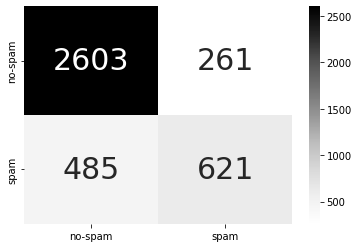

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

#### **Task 2**

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(64, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(4, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 100, 300)     5031600     input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 100, 300)     0           embedding_3[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 100, 128)     186880      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1, 
          validation_data=(dev_X, dev_y_spam))

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56/56 [==============================] - 9s 92ms/step - loss: 1.2470 - accuracy: 0.6656 - val_loss: 1.0812 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 4s 69ms/step - loss: 0.8768 - accuracy: 0.7400 - val_loss: 0.7843 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 4s 69ms/step - loss: 0.7383 - accuracy: 0.7401 - val_loss: 0.7446 - val_accuracy: 0.7281
Epoch 4/40
56/56 [==============================] - 4s 70ms/step - loss: 0.7039 - accuracy: 0.7404 - val_loss: 0.7148 - val_accuracy: 0.7294
Epoch 5/40
56/56 [==============================] - 4s 69ms/step - loss: 0.6709 - accuracy: 0.7481 - val_loss: 0.6844 - val_accuracy: 0.7451
Epoch 6/40
56/56 [==============================] - 4s 69ms/step - loss: 0.6396 - accuracy: 0.7850 - val_loss: 0.6571 - val_accuracy: 0.7892
Epoch 7/40
56/56 [==============================] - 4s 69ms/step - loss: 0.6072 - accuracy: 0.8130 - val_loss: 0.6315 - val_accuracy: 0.7980
Epoch 8/40
56/56 [======

In [ ]:
BILSTM_MODEL = os.path.join(MODEL_DIR, 'BiLSTM_task2.h5')
model.save(BILSTM_MODEL, save_format='h5')

F1 - micro: 0.8083123425692695
F1 - macro: 0.5819454865563078
Accuracy: 0.8083123425692695


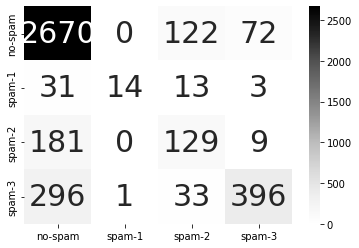

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)

### **GRU**

#### **Task 1**

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(2, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 100, 300)     5031600     input_5[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 100, 300)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 100, 160)     183360      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y)) 

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


56/56 [==============================] - 9s 88ms/step - loss: 0.6462 - accuracy: 0.6861 - val_loss: 0.5968 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 4s 73ms/step - loss: 0.5582 - accuracy: 0.7400 - val_loss: 0.5453 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 4s 73ms/step - loss: 0.5225 - accuracy: 0.7401 - val_loss: 0.5253 - val_accuracy: 0.7281
Epoch 4/40
56/56 [==============================] - 4s 72ms/step - loss: 0.5005 - accuracy: 0.7429 - val_loss: 0.5002 - val_accuracy: 0.7382
Epoch 5/40
56/56 [==============================] - 4s 73ms/step - loss: 0.4760 - accuracy: 0.7761 - val_loss: 0.4787 - val_accuracy: 0.7879
Epoch 6/40
56/56 [==============================] - 4s 72ms/step - loss: 0.4526 - accuracy: 0.8107 - val_loss: 0.4604 - val_accuracy: 0.7999
Epoch 7/40
56/56 [==============================] - 4s 72ms/step - loss: 0.4290 - accuracy: 0.8229 - val_loss: 0.4455 - val_accuracy: 0.8137
Epoch 8/40
56/56 [======

In [ ]:
GRU_MODEL = os.path.join(MODEL_DIR, 'GRU_task1.h5')
model.save(GRU_MODEL, save_format='h5')

F1 - micro: 0.8173803526448362
F1 - macro: 0.758442429737233
Accuracy: 0.8173803526448362


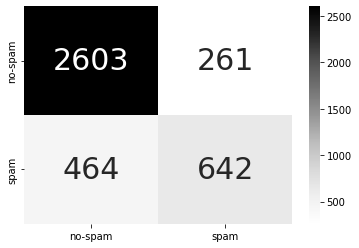

In [ ]:
show_predict_result(model, test_X, test_y, labels_task_1)

#### **Task 2**

In [ ]:
input = Input(shape=(sequence_length,))
x = Embedding(num_words, embedding_dim, weights=[embedding_matrix])(input)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(GRU(80, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
output = Dense(4, activation="softmax")(conc)

model = Model(inputs=input, outputs=output)
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 100, 300)     5031600     input_8[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 100, 300)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_5 (Bidirectional) (None, 100, 160)     183360      spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(train_X, train_y_spam,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(dev_X, dev_y_spam)) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/40
56/56 [==============================] - 8s 88ms/step - loss: 1.1223 - accuracy: 0.7340 - val_loss: 0.9570 - val_accuracy: 0.7281
Epoch 2/40
56/56 [==============================] - 4s 72ms/step - loss: 0.8315 - accuracy: 0.7400 - val_loss: 0.7755 - val_accuracy: 0.7281
Epoch 3/40
56/56 [==============================] - 4s 72ms/step - loss: 0.7261 - accuracy: 0.7400 - val_loss: 0.7262 - val_accuracy: 0.7281
Epoch 4/40
56/56 [==============================] - 4s 71ms/step - loss: 0.6873 - accuracy: 0.7411 - val_loss: 0.6959 - val_accuracy: 0.7369
Epoch 5/40
56/56 [==============================] - 4s 72ms/step - loss: 0.6575 - accuracy: 0.7569 - val_loss: 0.6684 - val_accuracy: 0.7772
Epoch 6/40
56/56 [==============================] - 4s 72ms/step - loss: 0.6288 - accuracy: 0.7979 - val_loss: 0.6437 - val_accuracy: 0.7867
Epoch 7/40
56/56 [==============================] - 4s 72ms/step - loss: 0.6010 - accuracy: 0.8075 - val_loss: 0.6227 - val_accuracy: 0.7923
Epoch 8/40
56

In [ ]:
GRU_MODEL = os.path.join(MODEL_DIR, 'GRU_task2.h5')
model.save(GRU_MODEL, save_format='h5')

F1 - micro: 0.8183879093198992
F1 - macro: 0.641403791637932
Accuracy: 0.8183879093198992


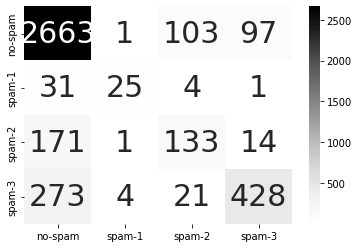

In [ ]:
show_predict_result(model, test_X, test_y_spam, labels_task_2)